# Model solutions for Lab 9 (including relevant parts of Lab 8)

# Lab 8

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
signal = pd.read_csv('signal_training.dat', sep=" ")
backgr = pd.read_csv('background_training.dat', sep=" ")

In [3]:
# All operations will be easier if we concatenate signal and background into one dataframe, and use signal_true to distinguish them.
df = pd.concat((signal,backgr)).drop(columns=['event_true','reaction_true']).sample(frac=1).reset_index(drop=1)
# If we replace all -999.9 with np.NaN, pandas automatically excludes them.
df = df.replace(-999.9,np.NaN)

In [4]:
def metric(df,var,val,lr,df_kept=None):
    '''
    This calculates the metric (eff*pur) of the proportion of kept states.
    This can be done in 2 ways. We can either pass a dataframe to cut, and 
    the variable and value to cut on, or pass the kept frame directly.
    '''
    if type(df_kept)==type(None):
        if lr.lower()=='r':
            df_kept = df[df[var]>val]
        if lr.lower()=='l':
            df_kept = df[df[var]<val]
    
    total_kept   = len(df_kept) 
    signal_kept  = len(df_kept[df_kept['signal_true']==1])
    total_signal = len(signal)
    eff = signal_kept/total_signal
    
    if total_kept>0:
        pur = signal_kept/total_kept
    else:
        pur = 0
    return eff*pur

def metricCurves(df,var):
    '''
    This is used anywhere we need to get either the value of metric at many
    cut points, or find an optimum cut point. So it is used in Ex. 4 and 5.
    '''
    nVals = 50
    varSpace = np.linspace(df[var].min(),df[var].max(),nVals)
    Louts = np.zeros(nVals)
    Routs = np.zeros(nVals)
    for i,v in enumerate(varSpace):
        Louts[i] = metric(df,var,v,'l')
        Routs[i] = metric(df,var,v,'r')
    LBestIndex = np.argmax(Louts)
    RBestIndex = np.argmax(Routs)
    LBest = Louts[LBestIndex]
    RBest = Routs[RBestIndex]
    if LBest>RBest:
        bestMetric = LBest
        bestCut = varSpace[LBestIndex] 
        bestDir = 'L'
        bestOuts = Louts
    else:
        bestMetric = RBest
        bestCut = varSpace[RBestIndex]
        bestDir = 'R'
        bestOuts = Routs
    return bestMetric, bestCut, bestDir, varSpace, bestOuts

In [5]:
# Here we create modelTable, which is the best metrics on the training data.

names   = []
metrics = []
cuts    = []
dirs    = []

varibs = list(df)[1:]
for var in varibs:
    names.append(var)
    bestMetric, bestCut, bestDir, varSpace, bestOuts = metricCurves(df,var)
    metrics.append(bestMetric)
    cuts.append(bestCut)
    dirs.append(bestDir)

modelTable = pd.DataFrame({
    'Name':names,
    'Metric value':metrics,
    'Best cut':cuts,
    'Directions':dirs
})
modelTable = modelTable[['Name','Metric value','Best cut','Directions']] # Enforce a column order.

In [6]:
display(modelTable.sort_values('Metric value',ascending=False).reset_index(drop=1))

,Name,Metric value,Best cut,Directions
0,effpully,0.789176,-0.353368,R
1,efftime,0.693480,0.453600,L
2,effpullx,0.673517,0.081554,R
3,nue,0.634709,2080.459095,R
4,piontotale,0.606841,126.974144,R
5,energybalance,0.598936,-72.505588,R
6,ntracks,0.578387,0.000000,R
7,muonz,0.499925,-209.285116,R
8,muonpos,0.499925,2964.929813,L
9,pospions,0.497751,3.020408,L


## Lab 9

### 1. Test data

In [7]:
# Perform the same cleaning operations on the test data as on training.

signal_test = pd.read_csv('signal_data.dat', sep=" ")
backgr_test = pd.read_csv('background_data.dat', sep=" ")
df_test = pd.concat(
    (signal_test,backgr_test)
).drop(columns=['event_true','reaction_true']).sample(frac=1).reset_index(drop=1)
df_test = df_test.replace(-999.9,np.NaN)

In [8]:
def splitData(df,var,modelTable=None,cut=None,direc=None):
    '''
    Used for splitting test data on an existing model (represented by modelTable).
    '''
    if type(cut)==type(None):
        cut   = modelTable.loc[modelTable['Name']==var, 'Best cut'].values[0]
    if type(direc)==type(None):
        direc = modelTable.loc[modelTable['Name']==var, 'Directions'].values[0]
    if direc=='L':
        return df[df[var]<cut]
    if direc=='R':
        return df[df[var]>cut]

In [9]:
test_mets = []
for var in varibs:
    df_kept = splitData(df_test,var,modelTable)
    test_mets.append(
        metric(df_test,var=None,val=None,lr=None,df_kept=df_kept)
    )
modelTable['Test metrics'] = test_mets

In [10]:
display(modelTable.sort_values('Metric value',ascending=False).reset_index(drop=1))

,Name,Metric value,Best cut,Directions,Test metrics
0,effpully,0.789176,-0.353368,R,0.754928
1,efftime,0.693480,0.453600,L,0.676325
2,effpullx,0.673517,0.081554,R,0.643333
3,nue,0.634709,2080.459095,R,0.631654
4,piontotale,0.606841,126.974144,R,0.547169
5,energybalance,0.598936,-72.505588,R,0.583536
6,ntracks,0.578387,0.000000,R,0.544538
7,muonz,0.499925,-209.285116,R,0.485051
8,muonpos,0.499925,2964.929813,L,0.485051
9,pospions,0.497751,3.020408,L,0.485051


### 2. Combined splits

In [11]:
def applyNCombined(df,n,modelTable):
    '''
    This takes the top n variables, and iteratively cuts them. It produces
    df_kept by splitting the previous df_kept, and then evaluates the metric
    at each number of variables.
    '''
    outs = []
    topVars = modelTable.sort_values('Metric value',ascending=False)['Name'].values
    df_kept = df.copy()
    for var in topVars[:n+1]:
        df_kept = splitData(df_kept,var,modelTable)
        outs.append(metric(df_test,var,val=None,lr=None,df_kept=df_kept))
    return outs

In [12]:
combinedMets = applyNCombined(df_test,6,modelTable)
for i,c in enumerate(combinedMets):
    print('Combined {} best variables   ---   Metric = {:2.3f}'.format(i+1,c))

Combined 1 best variables   ---   Metric = 0.755
Combined 2 best variables   ---   Metric = 0.735
Combined 3 best variables   ---   Metric = 0.668
Combined 4 best variables   ---   Metric = 0.599
Combined 5 best variables   ---   Metric = 0.414
Combined 6 best variables   ---   Metric = 0.369
Combined 7 best variables   ---   Metric = 0.315


Combining variables without re-optimising results in a worse metric.

### 3. Plots

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


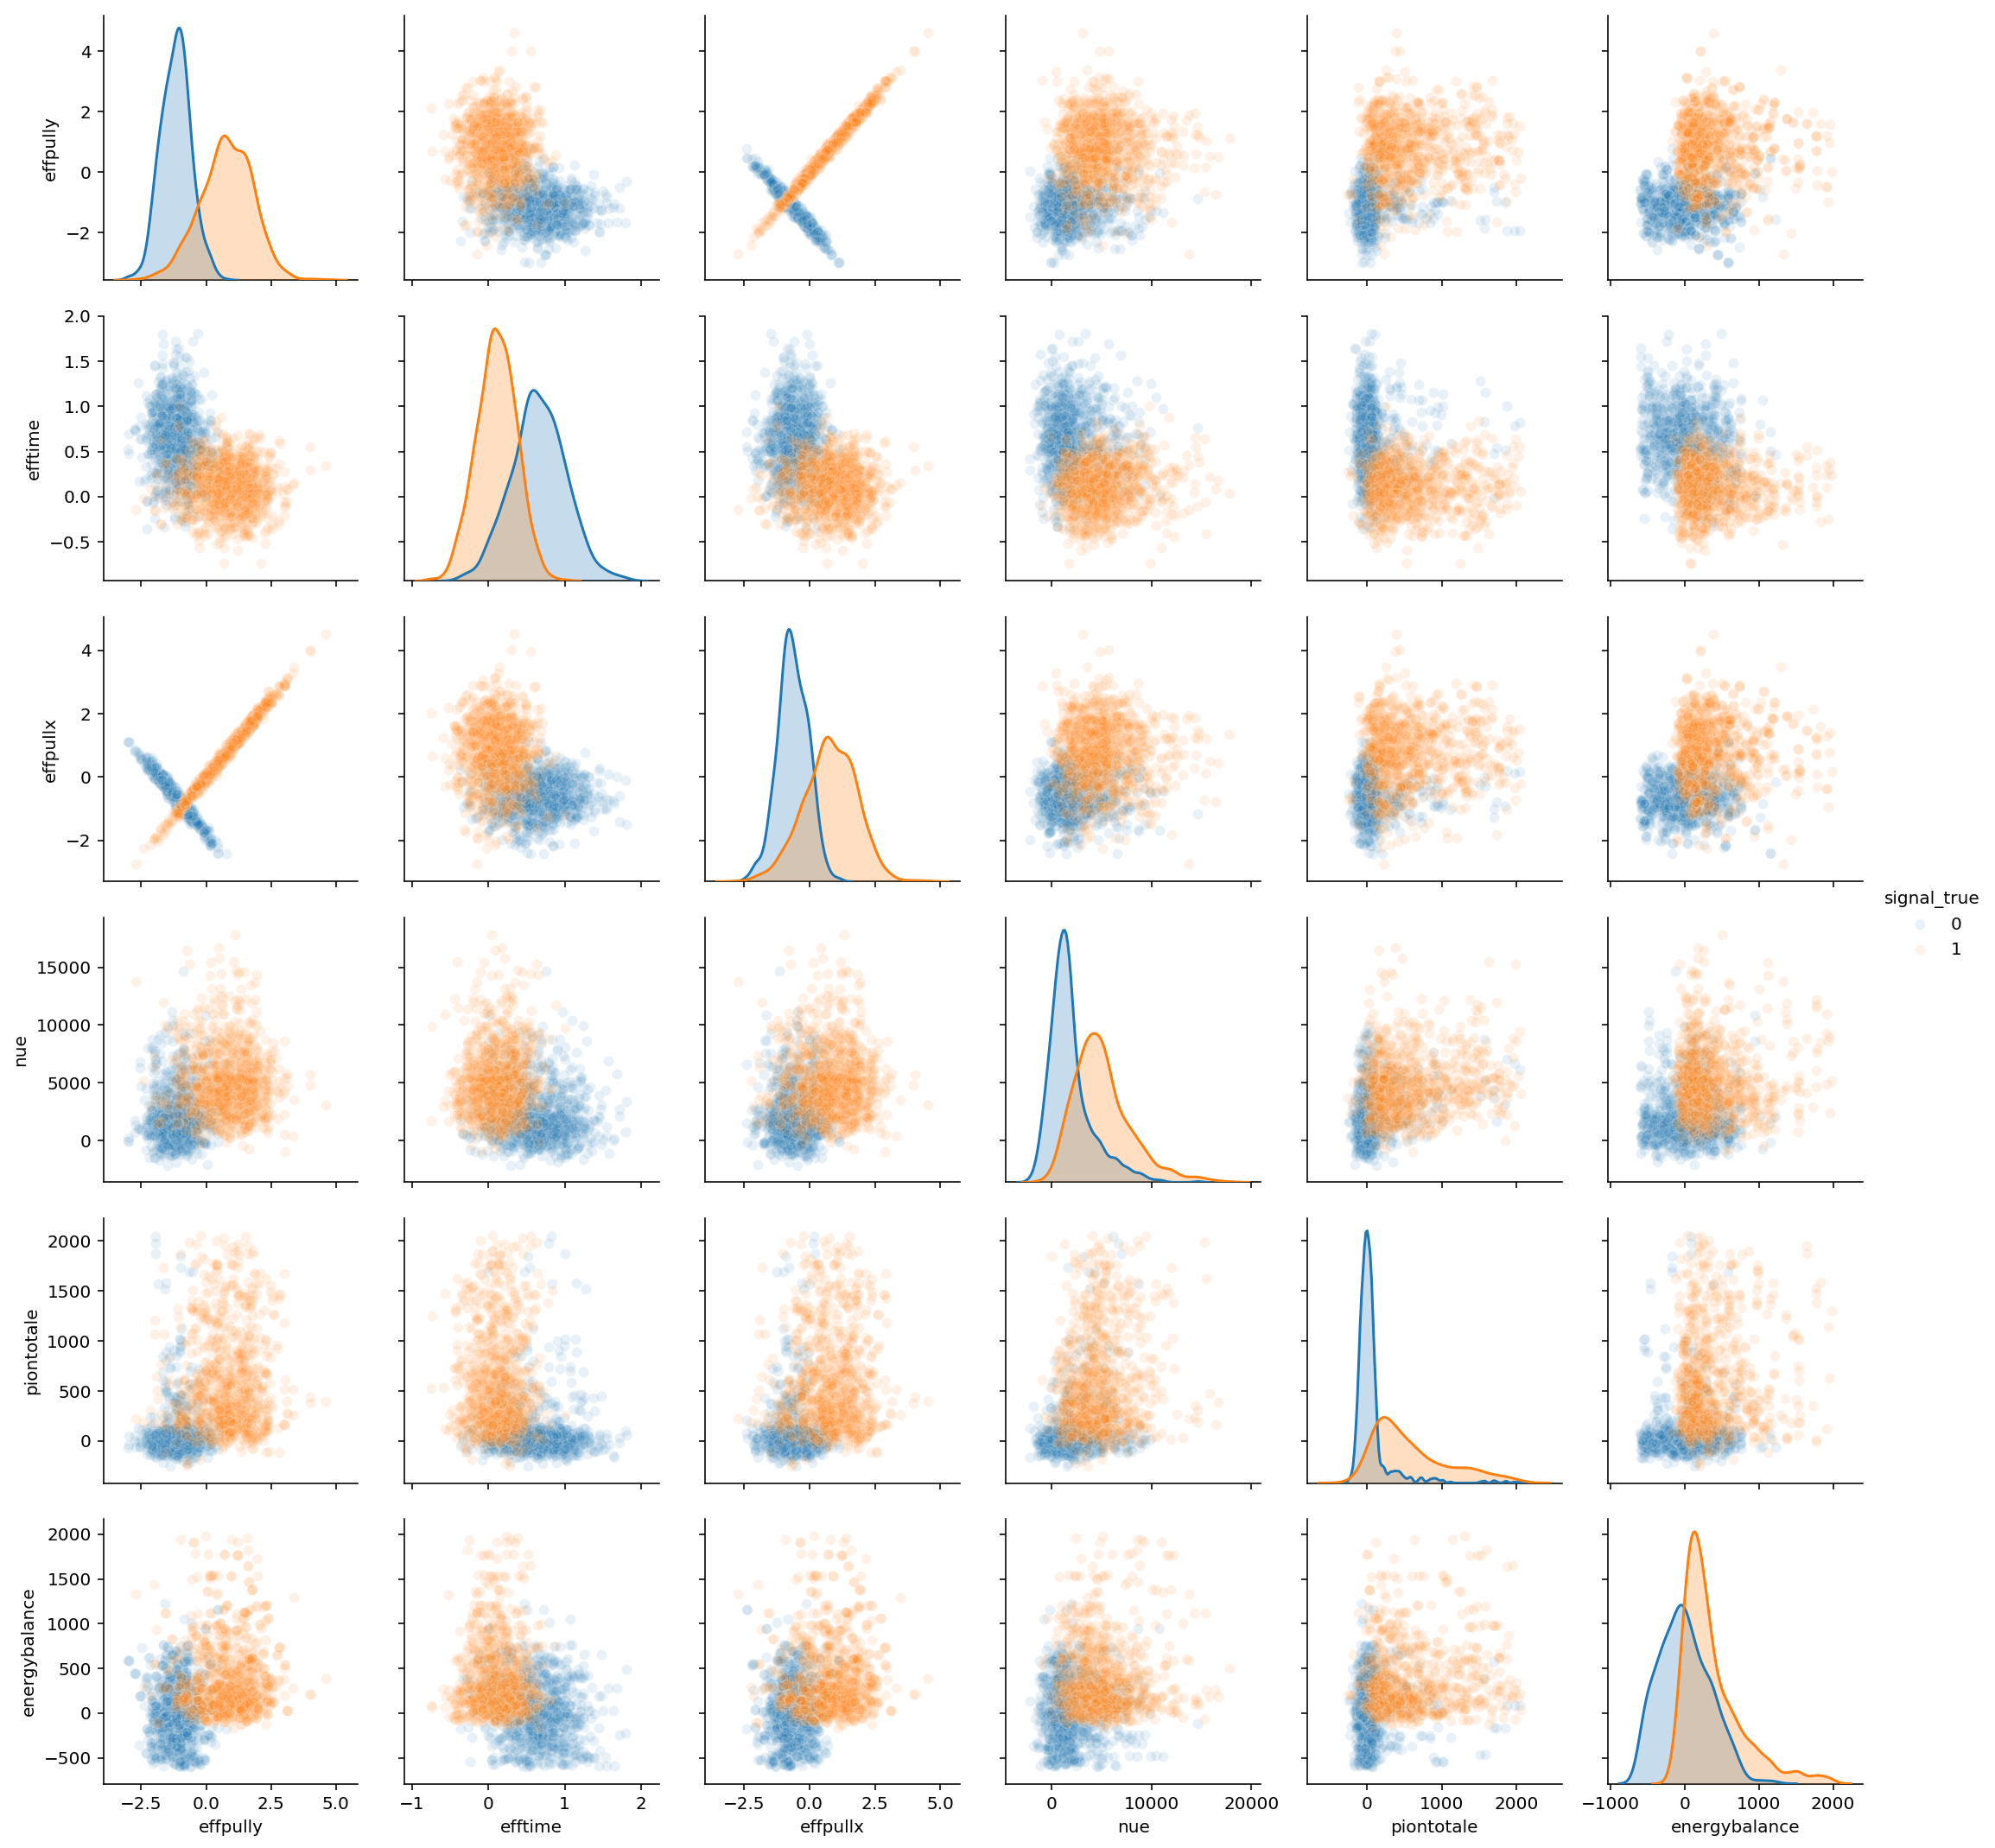

In [13]:
topVars = list(modelTable.sort_values('Metric value',ascending=False)['Name'].values)
sns.pairplot(data=df.sample(frac=1)[:int(len(df)*0.1)], # Take a sample of points for fast and clear plotting.
             x_vars=topVars[:6],
             y_vars=topVars[:6],
             hue='signal_true',
             plot_kws={'alpha': 0.1})

### 3+. New variable 

We see effpullx is positively correlated with effpully for signals, and negatively for backgrounds.
Therefore, since effpullx =  m * (effpully+1) - 1, we should construct a new variable,

effpulld = np.sign((effpullx+1)/(effpully+1))/2 + 1/2

Then cutting on this new variable *alone* would get an accuracy of 92% and a metric of 0.86. See below...

In [14]:
from sklearn.metrics import accuracy_score as accs
dfbonus = df.copy()
dfbonus['effpulld'] = np.sign( (dfbonus['effpully']+1) / (dfbonus['effpullx']+1) )/2 + 0.5
print('Accuracy = {:.2f}'.format(accs(dfbonus['effpulld'],dfbonus['signal_true'])))
print('Metric   = {:.2f}'.format(
    np.dot(dfbonus['effpulld'],dfbonus['signal_true'])**2/ (dfbonus['effpulld'].sum() * dfbonus['signal_true'].sum()) )) 

Accuracy = 0.92
Metric   = 0.86


### 4. 2D plot


In [15]:
def metric2D(df,var1,var2,modelTable):
    '''
    We loop through all cut values for effpullx and effpully, and perform a contourf plot.
    '''
    nVals = 50
    varSpace1 = np.linspace(df[var1].min(),df[var1].max(),nVals)
    varSpace2 = np.linspace(df[var2].min(),df[var2].max(),nVals)
    dir1 = modelTable.loc[modelTable['Name']==var1, 'Directions'].values[0]
    dir2 = modelTable.loc[modelTable['Name']==var2, 'Directions'].values[0]
    
    outs = np.zeros((nVals,nVals))
    for i,val1 in enumerate(varSpace1):
        for j,val2 in enumerate(varSpace2):
            df_kept = splitData(
                splitData(
                    df,
                    var1,modelTable=None,cut=val1,direc=dir1
                ),
                var2,modelTable=None,cut=val2,direc=dir2
            )
            outs[i,j] = metric(df_test,var=None,val=None,lr=None,df_kept=df_kept)
    return varSpace1,varSpace2, outs

Text(0,0.5,'effpully')

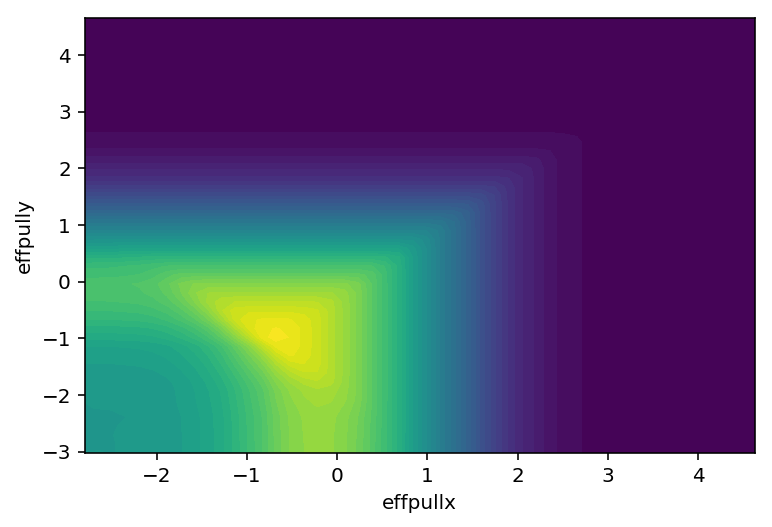

In [16]:
met2 = metric2D(df,'effpullx','effpully',modelTable)
plt.contourf(*met2,50)
plt.xlabel('effpullx')
plt.ylabel('effpully')

### 5. Decision tree

In [17]:
def decTree(df,depth):
    '''
    A decision tree is crucially different from exercise 2. In a decision tree, we have to 
    re-optimise the cut variable and cut position after each cut. If this is not done, the
    code is effectively the same as Ex 2.
    '''
    print('Level = ',end='')
    mets    = []
    varOuts = []
    df_kept = df.copy()
    for level in range(depth):
        print('{}... '.format(level+1),end='')
        bestMetric = 0
        bestCut = 0
        bestVar = ''
        bestDir = ''
        for var in varibs:
            metric, cut, direc, varSpace, bestOuts = metricCurves(df_kept,var)
            if metric>bestMetric:
                bestMetric = metric ; bestCut = cut ; bestVar = var ; bestDir = direc
        mets.append(bestMetric)
        varOuts.append(bestVar)
        df_kept = splitData(df_kept,bestVar,modelTable=None,cut=bestCut,direc=bestDir)
    return mets,varOuts

In [18]:
mets,varOuts = decTree(df_temp,5)
print('\nVariables cut on... = ', varOuts)

NameError: name 'df_temp' is not defined

In [19]:
plt.plot(np.arange(1,len(mets)+1),mets)
plt.xlabel('Tree depth')
plt.ylabel('Metric')

NameError: name 'mets' is not defined